In [9]:
# Library Imports 
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import my_functions as mf
from scipy.optimize import curve_fit
from scipy.fftpack import fft, ifft, fftfreq
from scipy.special import voigt_profile
from scipy.signal import convolve
import re
import ast
importlib.reload(mf)

<module 'my_functions' from '/Users/fergusayton/Documents/My Library/fayt3249/2024/Honours Thesis/sample_coupling_analysis/my_functions.py'>

In [10]:

def plot_spectrum_for_bfield(target_bfield, magnetic_fields, aligned_frequencies, s21_magnitudes, margin=1):
    """
    Plots the S21 spectrum for magnetic field values within a given margin of a target B field.
    
    Parameters:
        target_bfield (float): Target magnetic field value in mT.
        magnetic_fields (numpy array): 1D array of magnetic field values corresponding to spectra.
        aligned_frequencies (numpy array): 1D array of frequency values.
        s21_magnitudes (numpy array): 2D array of S21 values (shape: [num_spectra, num_frequencies]).
        margin (float, optional): Margin around the target B field for selection (default is 1 mT).
    """
    # Find indices of spectra corresponding to the target B field within margin
    matching_indices = np.where(np.isclose(magnetic_fields, target_bfield, atol=margin))[0]

    print(matching_indices)
    if len(matching_indices) == 0:
        print(f"No spectra found within ±{margin} mT of {target_bfield} mT.")
        return
    
    # Plot each matching spectrum
    plt.figure(figsize=(8, 6))
    for idx in matching_indices:
        plt.plot(aligned_frequencies, s21_magnitudes[idx], label=f"B = {magnetic_fields[idx]:.2f} mT")
    
    plt.xlabel("Frequency (GHz)")
    plt.ylabel("S21 Magnitude (dB)")
    plt.title(f"S21 Spectra for B-field ~ {target_bfield} mT")
    plt.legend()
    plt.grid()
    plt.show()

def plot_individual_spectrum(file_path):
    """
    Plots the S21 spectrum for a specified file.
    
    Parameters:
        file_path (str): Path to the VNA data file.
    """
    # Load data
    data = mf.read_VNA_data_magnets(file_path)
    
    # Extract frequency and S21 magnitude
    frequencies = data["Frequency (GHz)"].values
    s21_magnitude = data["S21 (dB)"].values
    magnetic_field = data["Magnetic Field (T)"].values * 1e3  # Convert to mT
    
    # Extract S21 features
    # features_2 = mf.extract_s21_features(frequencies, s21_magnitude)
    # loaded_q = features_2.get("Q_tot")
    # resonant_freq = features_2.get("f_res")
    # s21_max = features_2.get("S21_peak")
    
    # Plot spectrum
    plt.figure(figsize=(8, 6))
    plt.plot(frequencies, s21_magnitude, label=f"B = {magnetic_field[0]:.2f} mT")
    plt.xlabel("Frequency (GHz)")
    plt.ylabel("S21 Magnitude (dB)")
    #plt.title(f"S21 Spectrum for {file_path}")
    plt.xlim([3.923-0.01,3.923+0.01])
    plt.ylim([-80,-50])
    plt.legend()
    plt.grid()
    plt.show()

def read_VNA_data_magnets_revised(file_path):
    # Read CSV and ensure State column is treated as a single field
    raw_data = pd.read_csv(file_path, quotechar='"')  
    
    # Convert the 'State' column from string to actual Python list
    raw_data["State"] = raw_data["State"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else x)
    
    # Extract individual values from the 'State' list
    raw_data["State Device"] = raw_data["State"].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
    raw_data["Current Limit"] = raw_data["State"].apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else None)
    raw_data["Current Ramp Limit"] = raw_data["State"].apply(lambda x: x[2] if isinstance(x, list) and len(x) > 2 else None)
    raw_data["Coil Constant"] = raw_data["State"].apply(lambda x: x[3] if isinstance(x, list) and len(x) > 3 else None)
    raw_data["Current"] = raw_data["State"].apply(lambda x: x[4] if isinstance(x, list) and len(x) > 4 else None)
    raw_data["Calculated Supply Current"] = raw_data["State"].apply(lambda x: x[5] if isinstance(x, list) and len(x) > 5 else None)
    raw_data["Supply Voltage"] = raw_data["State"].apply(lambda x: x[6] if isinstance(x, list) and len(x) > 6 else None)
    raw_data["Calculated System Resistance"] = raw_data["State"].apply(lambda x: x[7] if isinstance(x, list) and len(x) > 7 else None)
    raw_data["Calculated Field"] = raw_data["State"].apply(lambda x: x[8] if isinstance(x, list) and len(x) > 8 else None)
    
    # Drop the original 'State' column (optional)
    raw_data.drop(columns=["State"], inplace=True)

    return raw_data

In [21]:

path = "data_vna/data_14_02_2025_magnet_ramp_up/"
data_files =  sorted(glob.glob(path +"*"))

aligned_frequencies = None
s21_magnitudes = []
spectra_times = []
magnetic_fields = []
loaded_q =[]
resonant_freq =[]
s21_max = []
calc_current = []
sent_current = []
sent_voltage = []
calc_resistance = []

 
# Process each file
for file in data_files:
    data = mf.read_VNA_data_magnets_revised(file)
    time_str = file.split('_')[-1]
    time_str = int(time_str.replace("-", ""))
    spectra_times.append(time_str)

    data["S21 (dB)"] = mf.convert_dB_2_linear(data["S21 (dB)"])
    data["S21 (dB)"]=mf.low_pass_band_filter_fft(1000, data["Frequency (GHz)"], data["S21 (dB)"], plot_check=False)

    features = mf.calculate_S21_features(data, [3.86, 4.06], to_print=False)
    features_2 = mf.extract_s21_features( data["Frequency (GHz)"],  data["S21 (dB)"])

    loaded_q.append(features_2.get("Q_tot"))
    resonant_freq.append(features_2.get("f_res"))
    s21_max.append(features_2.get("S21_peak"))
    calc_current.append(data["Calculated Supply Current"][0])
    sent_current.append(data["Current"][0])
    sent_voltage.append(data["Supply Voltage"][0])
    calc_resistance.append(data["Calculated System Resistance"][0])


    # loaded_q.append(features.get("Q_loaded"))
    # resonant_freq.append(features.get("f_r"))
    # s21_max.append(features.get("S_21_mag_at_f_r"))

    # Use the first file's frequencies as the reference grid
    if aligned_frequencies is None:
        aligned_frequencies = data["Frequency (GHz)"].values
    
    # Interpolate S21 data onto the reference frequency grid
    interp_s21 = np.interp(aligned_frequencies, data["Frequency (GHz)"], data["S21 (dB)"])
    s21_magnitudes.append(interp_s21)

    # Interpolate S21 data onto the reference frequency grid
    interp_B = np.interp(aligned_frequencies, data["Frequency (GHz)"], data["Magnetic Field (T)"])
    magnetic_fields.append(interp_B)


# Convert to 2D array for plotting
s21_magnitudes = np.array(s21_magnitudes)
magnetic_fields = np.array(magnetic_fields)
resonant_freq = np.array(resonant_freq)
s21_magnitudes = np.array(s21_magnitudes)
loaded_q = np.array(loaded_q)
print(magnetic_fields)
assert np.all(magnetic_fields == magnetic_fields[:, [0]]), "Not all values in each row are identical!"
magnetic_fields = magnetic_fields[:,0]
magnetic_fields = magnetic_fields*1e3
resonant_freq = resonant_freq.squeeze()



[[5.7830000e-06 5.7830000e-06 5.7830000e-06 ... 5.7830000e-06
  5.7830000e-06 5.7830000e-06]
 [2.8366400e-04 2.8366400e-04 2.8366400e-04 ... 2.8366400e-04
  2.8366400e-04 2.8366400e-04]
 [5.4720000e-04 5.4720000e-04 5.4720000e-04 ... 5.4720000e-04
  5.4720000e-04 5.4720000e-04]
 ...
 [9.0305217e-02 9.0305217e-02 9.0305217e-02 ... 9.0305217e-02
  9.0305217e-02 9.0305217e-02]
 [9.0570628e-02 9.0570628e-02 9.0570628e-02 ... 9.0570628e-02
  9.0570628e-02 9.0570628e-02]
 [9.0863093e-02 9.0863093e-02 9.0863093e-02 ... 9.0863093e-02
  9.0863093e-02 9.0863093e-02]]


In [5]:
import pandas as pd
import ast 


file = "data_vna/data_04_02_2025_magnet_ramp_fine_down/S21_LGD2_2025-02-05_03-52-46"
my_data = read_VNA_data_magnets_revised(file)
print(my_data["Current"][600])
print(my_data["Current"][6])
print(my_data.columns)

25.45338445
25.45338445
Index(['Frequency (GHz)', 'S21 (dB)', 'Date', 'Time', 'Magnetic Field (T)',
       'Current Limit', 'Current Ramp Limit', 'Coil Constant', 'Current',
       'Calculated Supply Current', 'Supply Voltage',
       'Calculated System Resistance', 'Calculated Field', 'State Device'],
      dtype='object')


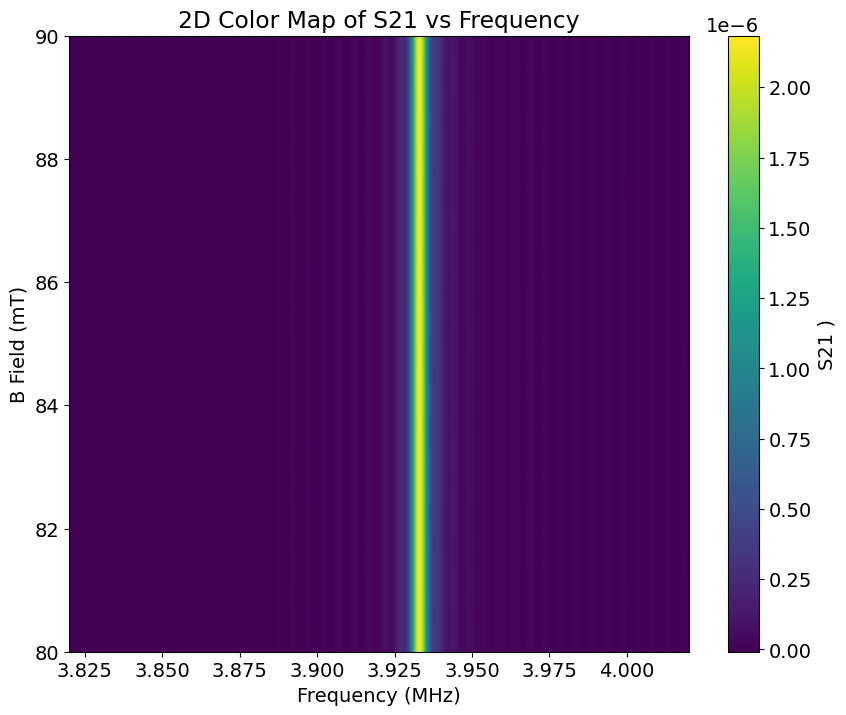

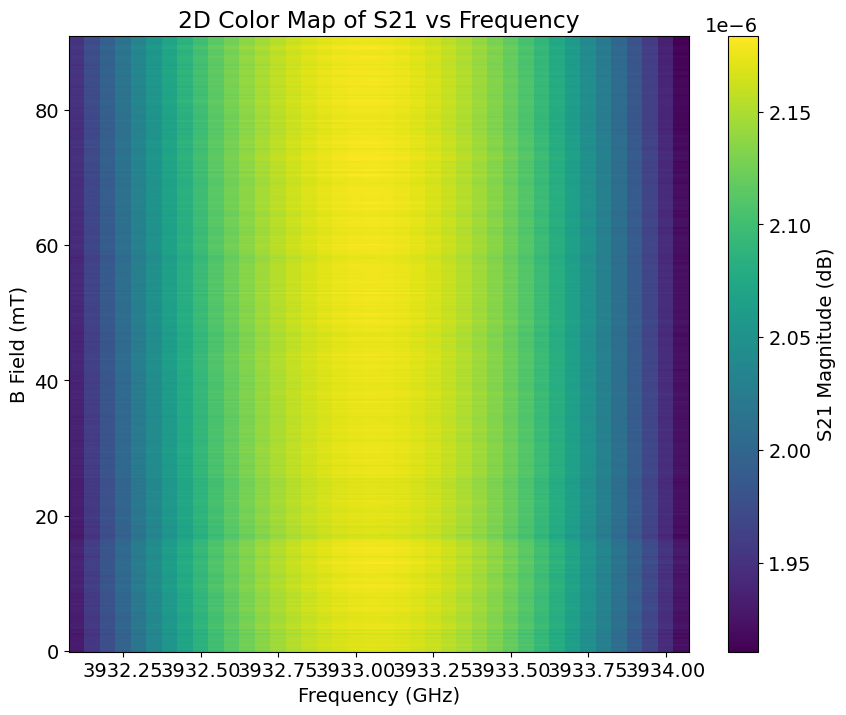

In [20]:
# Create a 2D color map plot
plt.figure(figsize=(10, 8))
plt.pcolormesh(aligned_frequencies, magnetic_fields, s21_magnitudes, shading='auto', cmap='viridis')
plt.colorbar(label="S21 )")
plt.xlabel("Frequency (MHz)")
plt.ylim([80,90])
plt.ylabel("B Field (mT)")
plt.title("2D Color Map of S21 vs Frequency")
plt.show()


lower_bound_freq= np.average(resonant_freq)-0.001
upper_bound_freq = np.average(resonant_freq)+0.001
zoom_mask = (aligned_frequencies >= lower_bound_freq) & (aligned_frequencies <= upper_bound_freq)
zoomed_frequencies = aligned_frequencies[zoom_mask]
zoomed_s21_magnitudes = s21_magnitudes[:, zoom_mask]
lower_bound_b = 40 
upper_bound_b = 50
zoomed_mask_magentic_fields = (magnetic_fields >= lower_bound_b) & (magnetic_fields <= upper_bound_b)
zoomed_magnetic_fields = magnetic_fields[zoomed_mask_magentic_fields]

plt.figure(figsize=(10, 8))
plt.pcolormesh(zoomed_frequencies*1E3,magnetic_fields, zoomed_s21_magnitudes, shading='auto', cmap='viridis')
#plt.ylim([80,90])
plt.colorbar(label="S21 Magnitude (dB)")
plt.xlabel("Frequency (GHz)")
plt.ylabel("B Field (mT)")
plt.title("2D Color Map of S21 vs Frequency")
plt.show()


In [ ]:
print(np.array(sent_current).shape)
#print(calc_current)

(987, 6001)


In [ ]:
plot_spectrum_for_bfield(47,aligned_frequencies,magnetic_fields,s21_magnitudes,margin=5)
print("Min B-field:", np.min(magnetic_fields))
print("Max B-field:", np.max(magnetic_fields))
print("Target range:", target_bfield - margin, "to", target_bfield + margin)
print("Matching B-fields:", magnetic_fields[(magnetic_fields >= target_bfield - margin) & (magnetic_fields <= target_bfield + margin)])


[]
No spectra found within ±5 mT of 47 mT.
Min B-field: -0.008236
Max B-field: 90.85532500000001


NameError: name 'target_bfield' is not defined

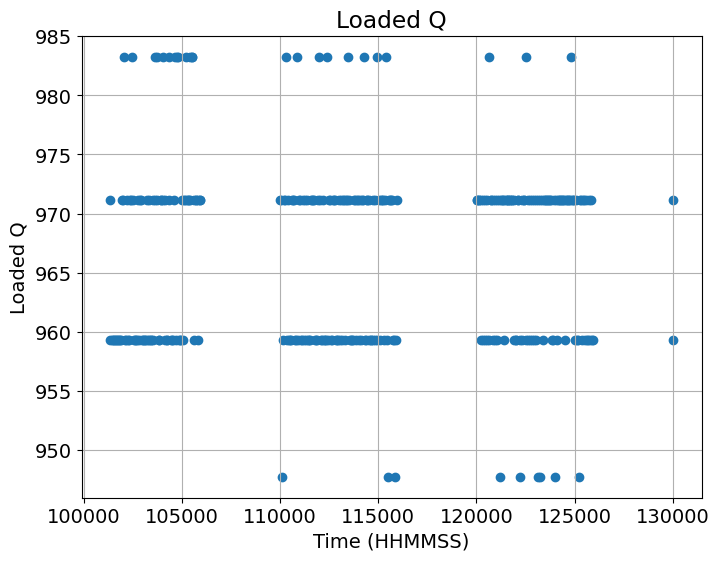

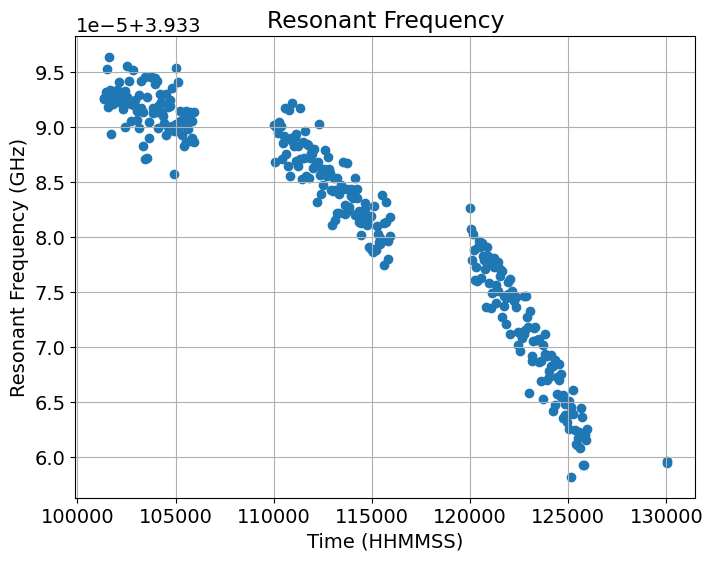

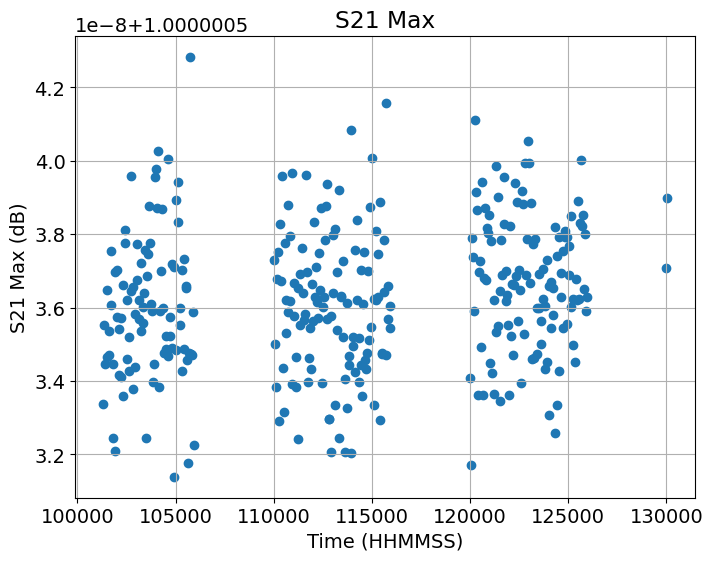

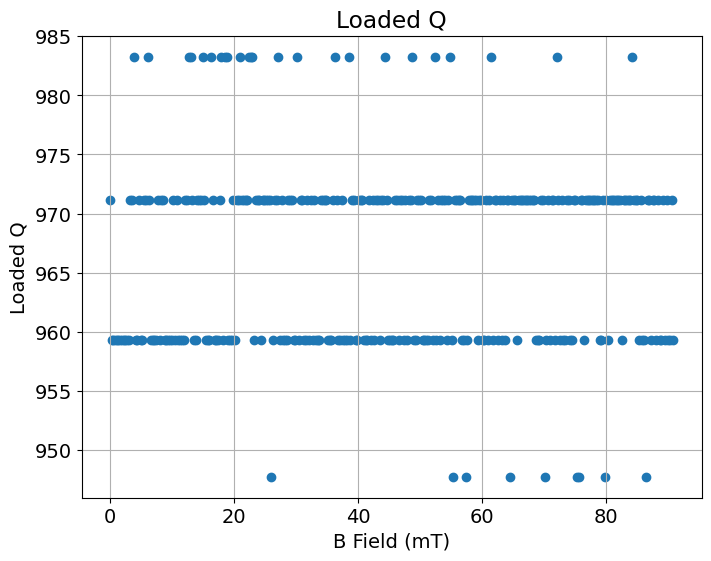

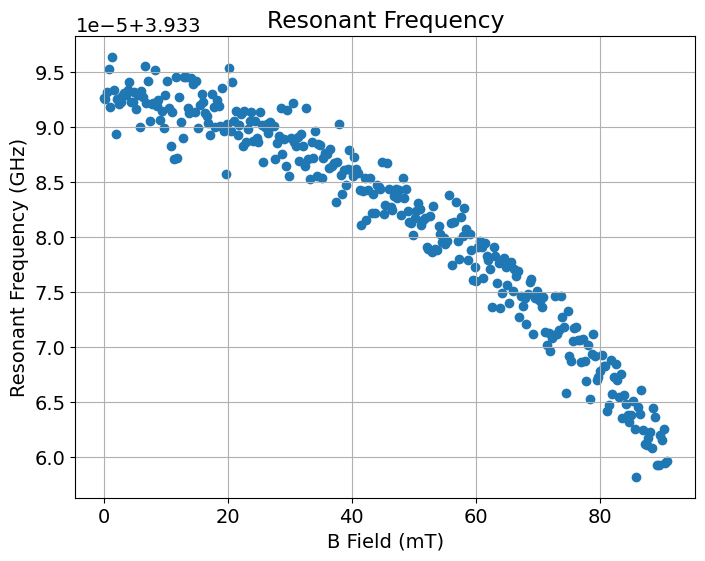

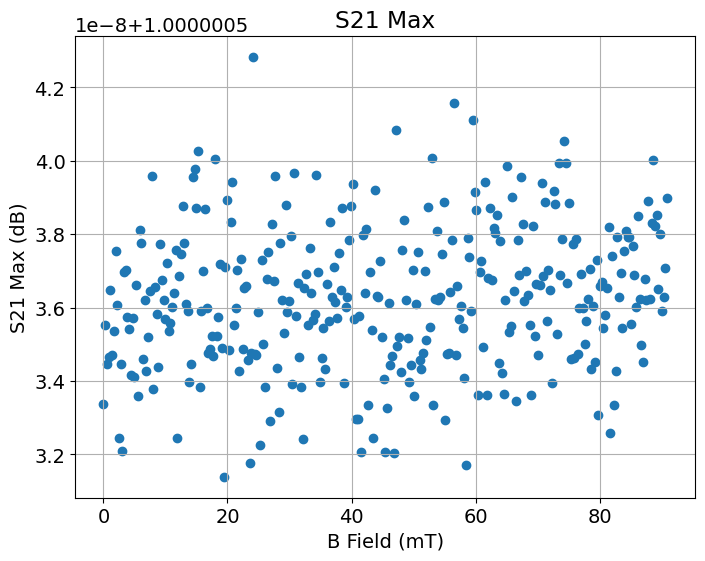

In [17]:
# First Plot: Loaded Q
fig1 = plt.figure(figsize=(8,6))
plt.rc("font", size=14)
plt.scatter(spectra_times, loaded_q, label="Loaded Q, f1", marker="o")
plt.xlabel("Time (HHMMSS)")
plt.ylabel("Loaded Q")
plt.title("Loaded Q")
plt.grid()
plt.show()

# Second Plot: Resonant Frequency
fig2 = plt.figure(figsize=(8,6))
plt.rc("font", size=14)
plt.scatter(spectra_times, resonant_freq, label="Resonant Frequency", marker="o")
plt.xlabel("Time (HHMMSS)")
plt.ylabel("Resonant Frequency (GHz)")
plt.title("Resonant Frequency")
plt.grid()
plt.show()

# Third Plot: S21 Max
fig3 = plt.figure(figsize=(8,6))
plt.rc("font", size=14)
plt.scatter(spectra_times, s21_max, label="S21 Max", marker="o")
plt.xlabel("Time (HHMMSS)")
plt.ylabel("S21 Max (dB)")
plt.title("S21 Max")
plt.grid()
plt.show()

# First Plot: Loaded Q
fig1 = plt.figure(figsize=(8,6))
plt.rc("font", size=14)
plt.scatter(magnetic_fields, loaded_q, label="Loaded Q, f1", marker="o")
plt.xlabel("B Field (mT)")
plt.ylabel("Loaded Q")
plt.title("Loaded Q")
plt.grid()
plt.show()

# Second Plot: Resonant Frequency
fig2 = plt.figure(figsize=(8,6))
plt.rc("font", size=14)
plt.scatter(magnetic_fields, resonant_freq, label="Resonant Frequency", marker="o")
plt.xlabel("B Field (mT)")
plt.ylabel("Resonant Frequency (GHz)")
plt.title("Resonant Frequency")
plt.grid()
plt.show()

# Third Plot: S21 Max
fig3 = plt.figure(figsize=(8,6))
plt.rc("font", size=14)
plt.scatter(magnetic_fields, s21_max, label="S21 Max", marker="o")
plt.xlabel("B Field (mT)")
plt.ylabel("S21 Max (dB)")
plt.title("S21 Max")
plt.grid()
plt.show()




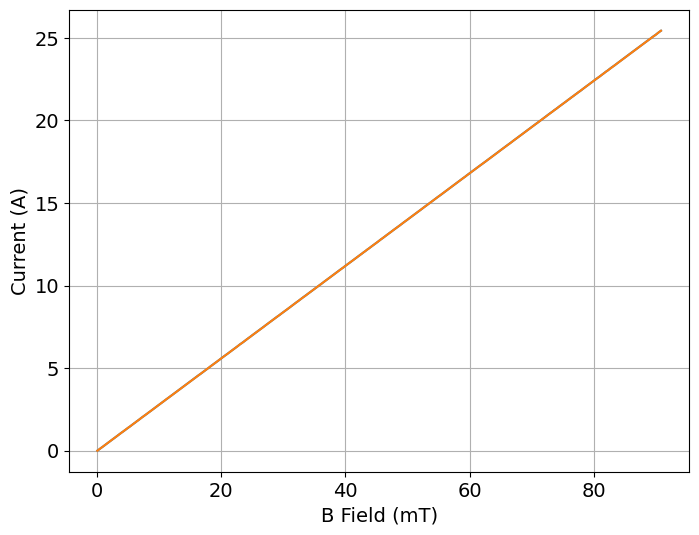

[-6.47377000e-03  7.09546300e-02  1.49037450e-01  2.26172880e-01
  3.01145320e-01  3.81020170e-01  4.54409830e-01  5.32018960e-01
  6.10857010e-01  6.86978480e-01  7.66404370e-01  8.45314720e-01
  9.24493300e-01  9.94858200e-01  1.07403107e+00  1.15281966e+00
  1.23252901e+00  1.30951225e+00  1.38836933e+00  1.46246478e+00
  1.54194583e+00  1.62207940e+00  1.69777474e+00  1.77118724e+00
  1.85138739e+00  1.93134214e+00  2.00749215e+00  2.08718246e+00
  2.16004517e+00  2.23943682e+00  2.31961414e+00  2.39202789e+00
  2.47072708e+00  2.54789866e+00  2.62824719e+00  2.70730783e+00
  2.78120923e+00  2.85724319e+00  2.93697346e+00  3.01672085e+00
  3.09556271e+00  3.17188583e+00  3.24608401e+00  3.32545283e+00
  3.40497764e+00  3.48010987e+00  3.55469233e+00  3.63436743e+00
  3.71459802e+00  3.78895409e+00  3.86688852e+00  3.94763085e+00
  4.02040795e+00  4.09778879e+00  4.17689508e+00  4.25905277e+00
  4.33266882e+00  4.40947895e+00  4.48884587e+00  4.56879300e+00
  4.64189541e+00  4.71987

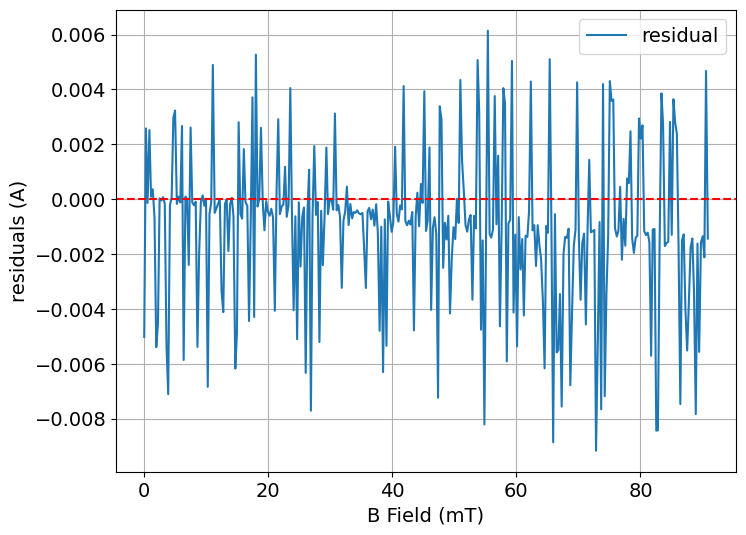

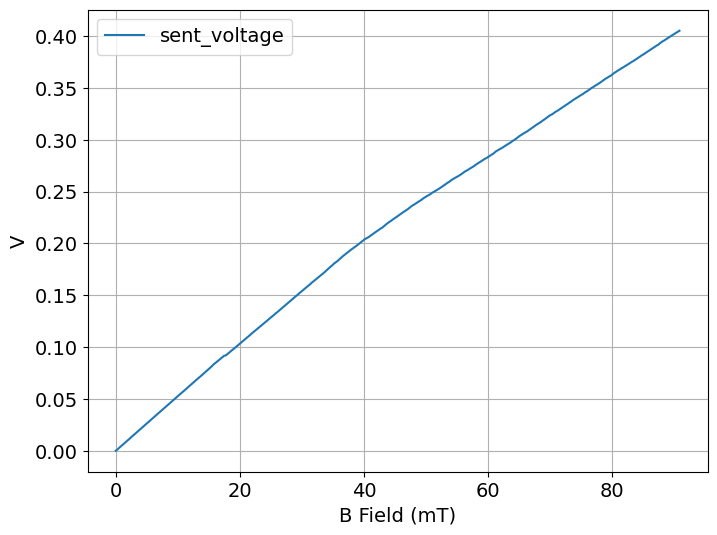

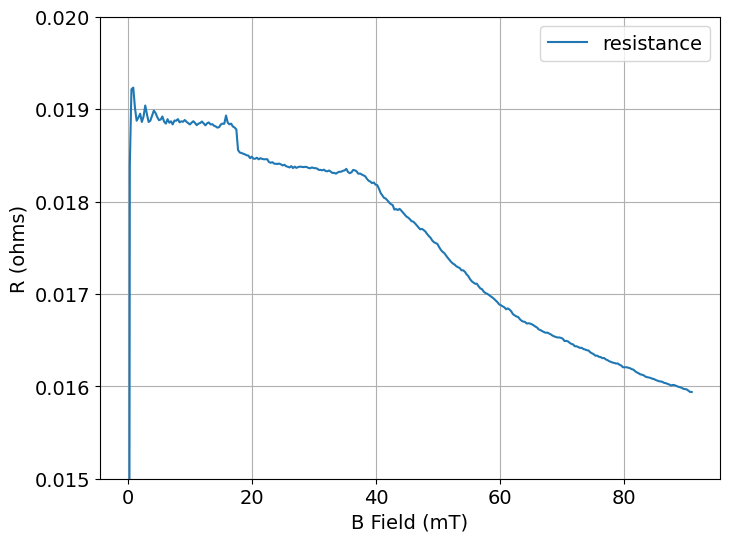

In [18]:

fig4 = plt.figure(figsize=(8,6))
plt.rc("font", size=14)
calc_current = np.array(calc_current)
sent_current = np.array(sent_current)
residules = sent_current - calc_current
plt.plot(magnetic_fields, calc_current, label="calc_current")
plt.plot(magnetic_fields, sent_current, label="sent_current")
plt.xlabel("B Field (mT)")
plt.ylabel("Current (A)")
plt.grid()
plt.show()

print(sent_current)
fig5 = plt.figure(figsize=(8,6))
plt.rc("font", size=14)
calc_current = np.array(calc_current)
sent_current = np.array(sent_current)
residuals = sent_current - calc_current
plt.plot(magnetic_fields, residuals, label="residual")
plt.axhline(0, linestyle="--", color="r")
plt.xlabel("B Field (mT)")
plt.ylabel("residuals (A)")
plt.grid()
plt.legend()
plt.show()


fig4 = plt.figure(figsize=(8,6))
plt.rc("font", size=14)
sent_voltage = np.array(sent_voltage)
plt.plot(magnetic_fields, sent_voltage, label="sent_voltage")
plt.xlabel("B Field (mT)")
plt.ylabel("V")
plt.grid()
plt.legend()
plt.show()

fig5 = plt.figure(figsize=(8,6))
plt.rc("font", size=14)
calc_resistance = np.array(calc_resistance)
plt.plot(magnetic_fields, calc_resistance, label="resistance")
plt.ylim([0.015, 0.020])
plt.xlabel("B Field (mT)")
plt.ylabel("R (ohms)")
plt.grid()
plt.legend()
plt.show()


DOWN RAMP